In [1]:
from nftools import guis
import pylsl
import time
import numpy as np
import mne, re
from multiprocessing import Process
import dynarray
from datetime import datetime
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types

In [2]:
%matplotlib qt  
# %gui qt
import warnings; warnings.filterwarnings('ignore') 

In [3]:
data_file = '/home/johan/nf/nf-rtime/Projects_Templates/3_RTMRICWL/trio2_eoec_outside_before.set'
raw = mne.io.read_raw_eeglab(data_file).resample(500)
raw_scaling = [item['cal'] for item in raw.info['chs']]

In [4]:
# raw.plot(scalings='auto');

In [5]:
# we need to transpose data, and then we can for-loop over it like so (extensively verbose):
def send_it(data_file):

    import mne
    # data_file = '/home/johan/nf/nf-rtime/Projects_Templates/3_RTMRICWL/trial_data_for_mri_cwl_development.set'

    raw = mne.io.read_raw_eeglab(data_file).resample(500)
    raw_scaling = [item['cal'] for item in raw.info['chs']]
    sfreq=raw.info['sfreq']
    
    print(raw)
    # create info for our purposes:
    info = pylsl.StreamInfo('Playback-3', 'EEG', len(raw.ch_names), raw.info['sfreq'], 'float32', 'someidentifier123')

    chns = info.desc().append_child("channels")
    for label in raw.ch_names:
        ch = chns.append_child("channel")
        ch.append_child_value("label", label)
        ch.append_child_value("unit", "microvolts")
        ch.append_child_value("type", "EEG")

    outlet = pylsl.StreamOutlet(info)

    # time_to_send_new_data_point = time.time()
    # time_to_wait_between_sending_data_points = 1/sfreq

    begin_time = time.time()
    current_time = 0.0
    all_data = raw.get_data().T / raw_scaling

    inds_sent = np.zeros(raw.last_samp+1, dtype=bool)
    while current_time < raw.last_samp/raw.info['sfreq']:

        inds_current = raw.times < current_time
        bool_slice = inds_current & ~inds_sent
        if bool_slice.any():
            b=np.min(np.where(bool_slice)[0])
            e=np.max(np.where(bool_slice)[0])+1


            stamp = pylsl.local_clock()-0.125
            outlet.push_chunk(all_data[b:e,:].tolist(), stamp)
            inds_sent = inds_sent | inds_current

            no_data_time=0

        time.sleep(0.01)
        current_time = time.time() - begin_time

    print('We are done sending this data')
    del(outlet)
        


In [14]:
p=Process(target=send_it, args=(data_file, ))

In [15]:
p.start()

<RawEEGLAB  |  trio2_eoec_outside_before.set, n_channels x n_times : 32 x 144870 (289.7 sec), ~35.5 MB, data loaded>
We are done sending this data


In [8]:
# prints out which streams are currently available
[ pylsl.stream_inlet(s).info().name() for s in pylsl.resolve_streams() ]

['Playback-3']

In [9]:
# which stream on  the network to read from?
stream_name = 'Playback-3'

# try grabbing all the information from that stream:
data_stream=pylsl.resolve_byprop("name", stream_name, timeout=5.0)
if data_stream:
    data_inlet=pylsl.stream_inlet(data_stream[0], max_buflen=10)
    stream_info = data_inlet.info()
    stream_Fs = stream_info.nominal_srate()
    stream_xml = stream_info.desc()
    chans_xml = stream_xml.child("channels")
    chan_xml_list = []
    ch = chans_xml.child("channel")
    while ch.name() == "channel":
        chan_xml_list.append(ch)
        ch = ch.next_sibling("channel")
    channel_names = [ch_xml.child_value("label") for ch_xml in chan_xml_list]
    data_inlet_dt = data_inlet.time_correction(timeout=5.0)
    sampling_freq = data_stream[0].nominal_srate()
    print('name = %s' % data_stream[0].name())
    print('sampling_freq = %d' % sampling_freq)
    print('channel_count = %d' % data_stream[0].channel_count())
    print('channel_format = %d' % data_stream[0].channel_format())
else:
    raise Exception('No Data Stream Found - Is your EEG Cap running?')

name = Playback-3
sampling_freq = 500
channel_count = 32
channel_format = 1


In [10]:
# clear EEG Data buffer

# we put the incoming data in here:
np_eo = dynarray.DynamicArray((None, len(channel_names)))

# we open up the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as we want:
while w.RUNLOOP:

    if data_inlet.samples_available():
        
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        np_eo.extend(chunk_data) # add to our list
        w.update(chunk_data) # update the GUI window
    else:
        w.update(None)

        

In [63]:
dt=datetime.datetime.now(tz=None).timestamp()

In [65]:
int(dt//1)

1586213404

In [69]:
dt%1

0.3830249309539795

In [70]:
# and we make the MNE data file from it    
info = mne.create_info(channel_names, 
                        sampling_freq, 
                        detect_channel_types(channel_names), 
                        'standard_1020')
dt=datetime.datetime.now(tz=None).timestamp()
info['meas_date'] = (int(dt//1), dt%1)
for chs in info['chs']: chs['cal']=1E-6
raw_eo=mne.io.RawArray(np.transpose(np_eo)*1E-6, info)   

In [74]:
raw_eo.save('test2.fif')

In [47]:
import datetime

In [51]:
info['meas_date'] = datetime.datetime.now(tz=None)

In [46]:
info['meas_date']

In [45]:
raw_eo.save('check_scaling_in_matlab.fif')

In [43]:
raw_eo.info['chs'][0]['cal']

1e-06

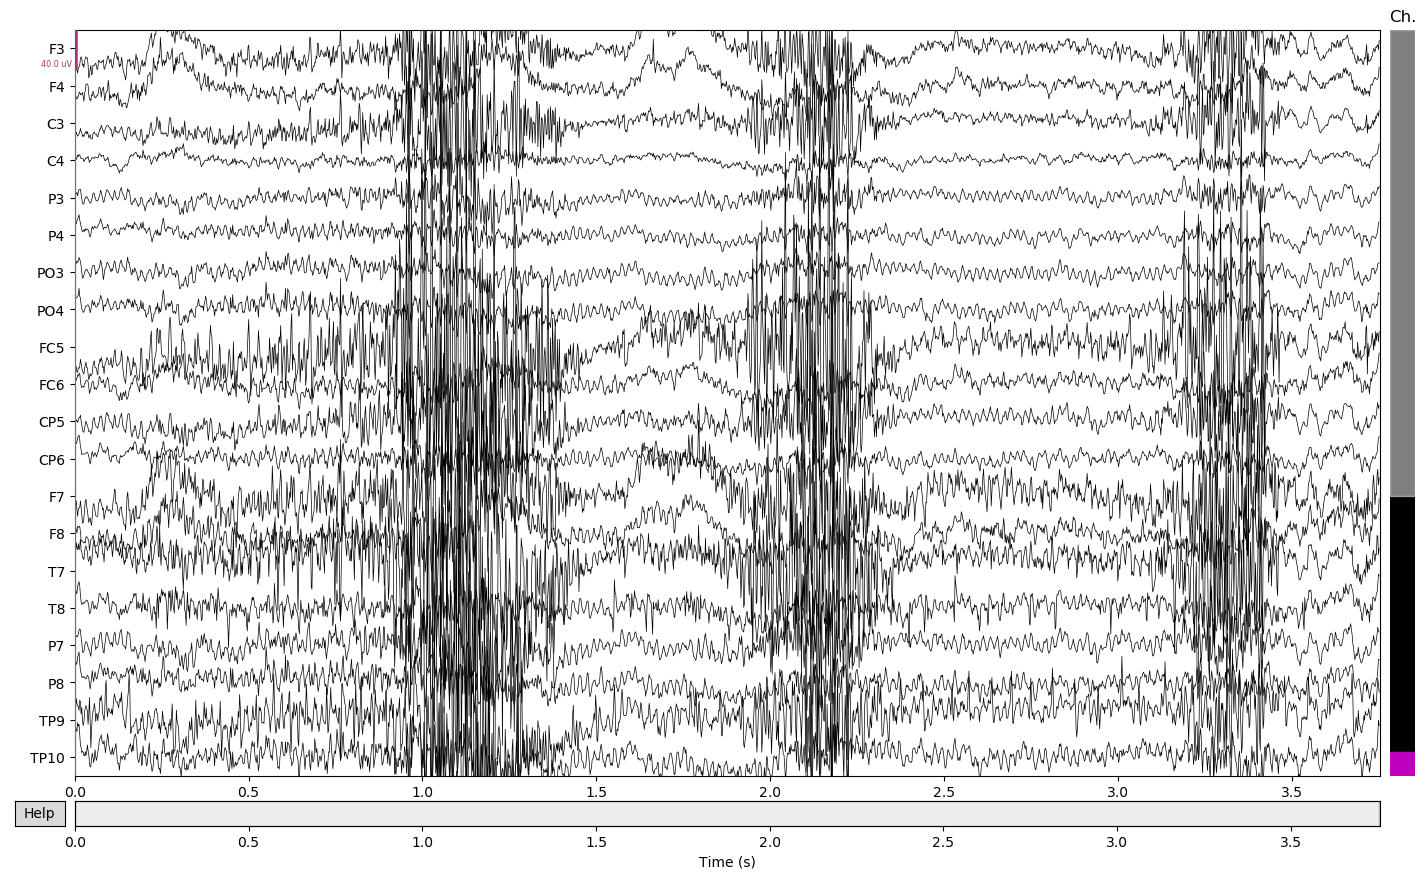

In [44]:
raw_eo.plot()

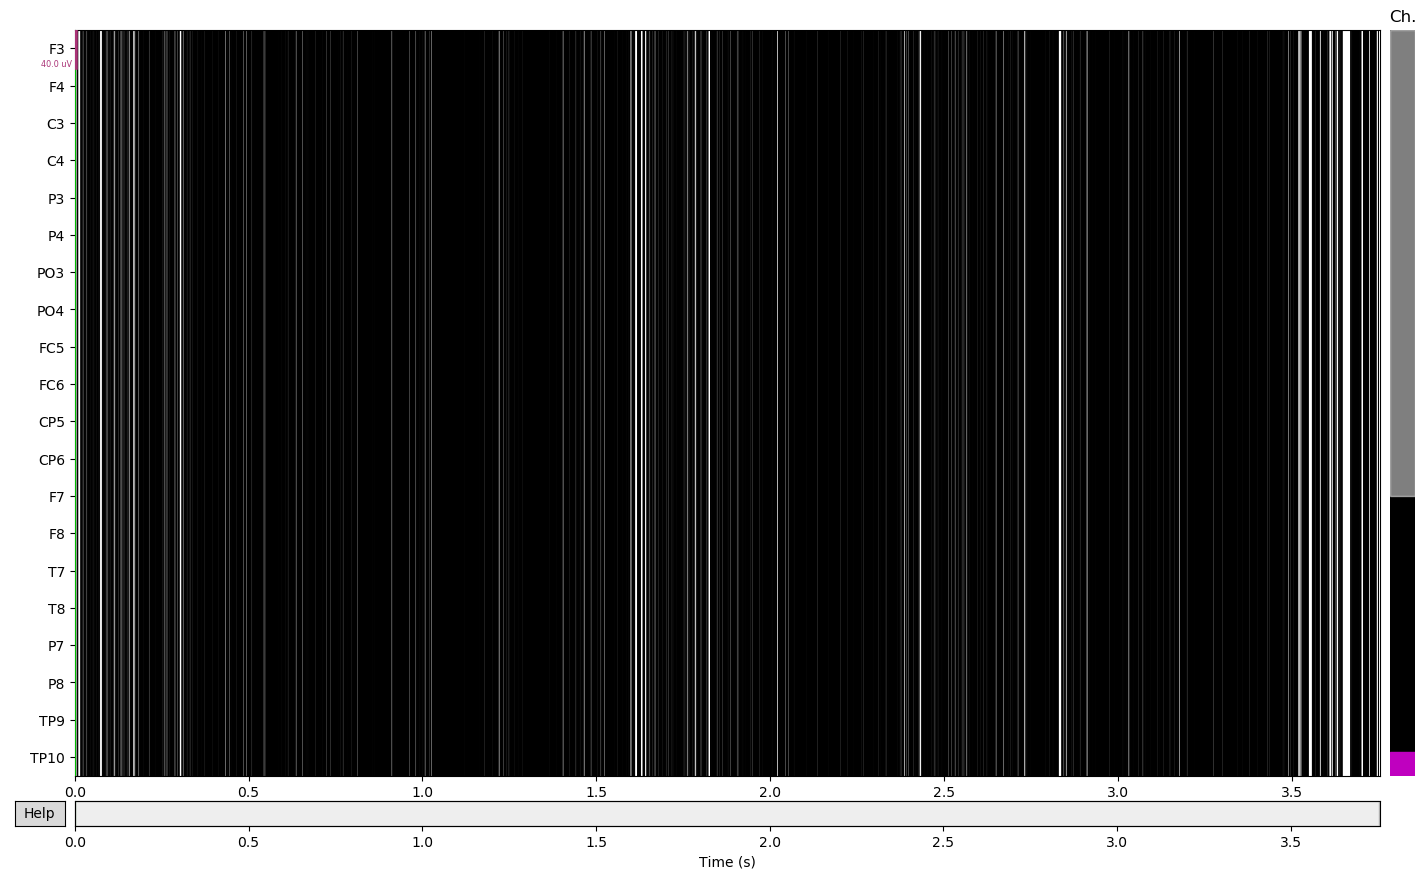

In [20]:
raw_eo.plot()

In [16]:
    
raw_eo = mne.io.RawArray(np.transpose(np_eo)*1E-6,
                    mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020')
                       )

In [30]:
ch_info = info['chs']

In [28]:
info['chs']

1

In [27]:
raw_eo.info['chs']

[{'loc': array([-0.04818205,  0.07634877,  0.08094884,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'F3',
  'scanno': 1,
  'logno': 1},
 {'loc': array([0.04965875, 0.07740367, 0.07957077, 0.        , 0.        ,
         0.        ,        nan,        nan,        nan,        nan,
                nan,        nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'F4',
  'scanno': 2,
  'logno': 2},
 {'loc': array([-0.06266714,  0.01605902,  0.10678042,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 na

In [13]:
raw_eo.info['chs'][]

[{'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'F3',
  'scanno': 1,
  'logno': 1},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'F4',
  'scanno': 2,
  'logno': 2},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'C3',
  'scanno': 3,
  'logno': 3},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit

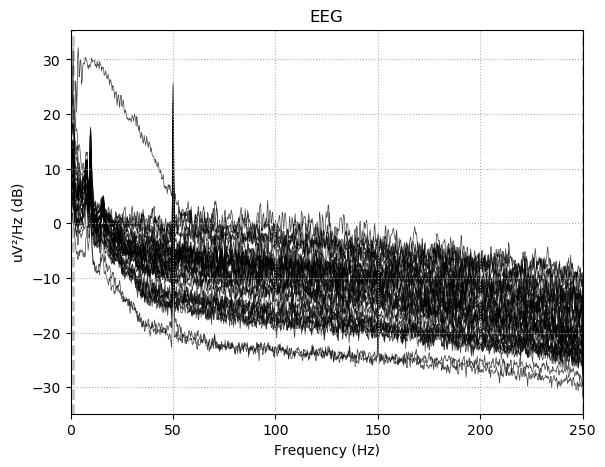

In [14]:
raw_eo.copy().filter(1, None).plot_psd()

In [ ]:
mne.create_info

In [4]:
v = np.squeeze(raw.copy().filter(12,15).get_data(picks=[10]).T*1E6)

In [5]:
v.shape

(144870,)

In [1]:
import numpy as np

In [2]:
v=np.loadtxt('test.txt')

In [3]:
import matplotlib.pyplot as plt
# plt.style.use('Solarize_Light2')

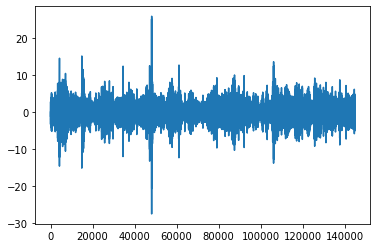

In [4]:
plt.figure()
plt.plot(v)

In [5]:
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types
from nftools.threshold import find_mode, contiguous_regions, detect_bursts, determine_optimal_threshold

1.8236117427405263

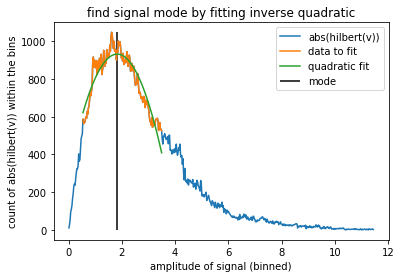

In [6]:
find_mode(v, make_plot=True)

In [7]:
np.diff(v)

array([-0.55205556, -0.53651381, -0.50534265, ...,  0.85520674,
        0.92288551,  0.95762328])

In [8]:
v[:-1]

array([-1.79994501e-15, -5.52055559e-01, -1.08856936e+00, ...,
       -2.73571553e+00, -1.88050879e+00, -9.57623278e-01])

In [9]:
%matplotlib qt

In [10]:
plt.plot(v[:-1], np.diff(v))

In [11]:
import scipy as sp
from scipy import signal

In [12]:
hv=sp.signal.hilbert(v)

In [13]:
m, edges_x, edges_y = np.histogram2d(v[:-1], np.diff(v), bins=100, range=[[-20, 20],[-5, 5]])

In [14]:
edge=5.

In [15]:
m, edges_x, edges_y = np.histogram2d(hv.real, hv.imag, bins=100, range=[[-edge, edge],[-edge, edge]])

In [16]:
plt.figure()
plt.imshow(m, extent=[-edge, edge,-edge, edge], vmin=0, vmax=100)
plt.colorbar()
plt.figure()
plt.plot(hv.real, hv.imag)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)

(-5.0, 5.0)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()


xdata = hv.real

line, = ax.plot(hv.real, hv.imag)


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(xdata))
    return line,


def animate(i):
    line.set_xdata(hv.real[i])  # update the data.
    line.set_ydata(hv.imag[i])  # update the data.
    line.set_marker('o')   
    line.set_color('k')   
    return line,

In [16]:
%matplotlib qt

In [21]:
plt.figure()
ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

In [22]:
plt.figure()

plt.plot(hv.real)
plt.plot(hv.imag)

In [18]:
ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)
# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

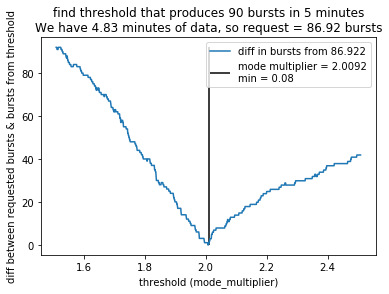

In [7]:
thr, _, _ = determine_optimal_threshold(v, 500, 0.2, 90, make_plot=True)

In [11]:
float(thr)

2.0092335980437968

In [261]:
from scipy.signal import hilbert
from scipy.optimize import curve_fit, fmin, fmin_bfgs
import matplotlib.pyplot as plt

def find_mode(v, make_plot=False):
    """ instead of determining the mean, or the median, we determine the mode to use as a threshold. 
        using a histogram approach and fit of a quadratic function"""
    ahv=abs(hilbert(v))
    [h, edges] = np.histogram(ahv, bins=500, range=(0, 5*np.median(ahv)))
    
    # define model; the inverse quadratic function
    model = lambda x, xoff, yoff, rc: yoff - rc*(x - xoff)**2
    
    # grab our x and y that we wish to fit; add half of the diff of the edges
    fit_x, fit_y = zip(*np.array([[te, th] for th, te in zip(h, edges) if th > 0.50 * max(h)]))
    fit_x += np.mean(np.diff(fit_x))/2
    
    # make initial (best) guesses
    init_xoff, init_yoff, init_rc = (np.mean(fit_x), max(fit_y), ((max(fit_y)-min(fit_y))/np.mean(fit_x))**0.5)
    
    # fit the model!
    global my_fitting_cov # dirty trick to allow us to access the covariance (for checking cov between fitting parameters)
                          # since it's a dirty trick, I will use a very unlikely name to be overwritten
    ((xoff, yoff, rc), cov) = curve_fit(model, fit_x, fit_y, p0=[init_xoff, init_yoff, init_rc], absolute_sigma=True)
    
    if make_plot:
        plt.figure()
        plt.plot(edges[:-1] + np.mean(np.diff(fit_x))/2, h) # plot our original histogram
        plt.plot(fit_x, fit_y) # plot the part that we try to fit
        plt.plot(fit_x, list(map(lambda x: model(x, xoff, yoff, rc), fit_x))) # plot the model!!
        plt.vlines(xoff, 0, init_yoff)
        plt.legend(['abs(hilbert(v))', 'data to fit', 'quadratic fit','mode'])
    
    # return the mode, which is xoff. we don't care about yoff and rc.
    return xoff


# from Joe Kington's answer here https://stackoverflow.com/a/4495197/3751373
# with minor edits
def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index.
    
    Works only on numpy vectors; so we expand it to work with the code
    obtained from stackoverflow.
    
    input MUST (likely) be a vector with no 1-dim dimensions
    """

    condition = np.expand_dims(condition, 1)
    
    # Find the indicies of changes in "condition"
    d = np.diff(condition,n=1, axis=0)
    idx, _ = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right. -JK
    # LB this copy to increment is horrible but I get 
    # ValueError: output array is read-only without it 

    mutable_idx = np.array(idx)
    mutable_idx +=  1
    idx = mutable_idx

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx


def detect_bursts(v, thr, dur):
    """ to prevent us from having to write this so many other times."""
    
    return [(b, e-b) for b, e in contiguous_regions(v > thr) if e-b > dur ]
    


def determine_optimal_threshold(v, fs, dur, bursts_per_5min, make_plot=False):
    """ uses the mode as well as find_consecutive_regions to optimize the threshold to 
        coincide with a number of bursts to be expected per 5 minutes.
        
        Uses Powell to optimize; not standard fminsearch or fmin.
    
        inputs
        ------
        
        v                 = the signal
        fs                = sampling rate
        dur               = desired burst duration
        bursts_per_5_min  = how many bursts you wish in a 5 minute interval
        make_plot         = if you wish to make a figure of convergence (True) or not (False [default])
        
        outputs
        -------
        thr               = multiplication of the MODE of the signal to reach N bursts
        nbursts           = how many bursts are actually detected at that threshold
        detected_bursts   = a list of onsets and durations (in samples!) of the bursts at optimum
        
        Note: The threshold is thr * find_mode(v); see find_mode function for more information.
        the mode is a reasonably unbiased estimate of the signal's power. Therefore the thr obtained
        with this method should be comparable across signal types, ranges, sampling rates and EEG systems (!) 
    
    """
    
    # pre-calculate to save computation time
    mode_v = find_mode(v)
    ahv = abs(hilbert(v))
    
    # how many bursts we need to have to fulfill criterion
    nbursts = len(v)/fs/60/5 * bursts_per_5min # we fit until we get 90 bursts
    
    # this is the function to minimize
    model = lambda thr: abs(nbursts - len([(b, e-b) for b, e in contiguous_regions(ahv > thr*mode_v) if e-b > dur*fs ]))
    
    # optimize!
    # xopt, = fmin(model, 1, disp=0) # backwards search
    tmp = scipy.optimize.minimize(model, 1, method="powell")
    xopt = tmp.x
    
    
    detected_bursts = detect_bursts(abs(hilbert(v)), 2*find_mode(v), 0.2*fs) # a list of onsets and durations (in sampless)
    
    if make_plot:
        plt.figure()
        xdata = np.arange(1000)*0.001 + xopt - 0.25
        ydata = list(map(model, xdata))
        plt.plot(xdata, ydata)
        plt.vlines(xopt, 0, max(ydata))
        plt.legend(['diff in bursts from {}'.format(nbursts), 'mode multiplier = {:2.4f}'.format(xopt)])
        
    
    return xopt, len(detected_bursts), detected_bursts
    

In [6]:
import matplotlib.pyplot as plt

In [9]:
%matplotlib qt

In [10]:
plt.plot([1,2,1,])

In [5]:
plt.figure()
plt.plot(v)

NameError: name 'plt' is not defined

In [12]:
plt.xlabel('test')
plt.ylabel('bla')
plt.title('title')

Text(0.5, 1, 'title')

In [263]:
find_mode(v, make_plot=True)

1.8236117427405263

In [267]:
cov

array([[9.17264553e-08, 7.27342278e-06, 1.78975128e-05],
       [7.27342278e-06, 1.67641247e-02, 1.23923923e-02],
       [1.78975128e-05, 1.23923923e-02, 1.76663994e-02]])

In [300]:
D = np.matrix(np.sqrt(np.diag(cov)))

In [308]:
cov / (D.T @ D)

matrix([[1.        , 0.18548171, 0.44460194],
        [0.18548171, 1.        , 0.72009648],
        [0.44460194, 0.72009648, 1.        ]])

In [266]:
plt.figure()
plt.imshow(cov)

In [259]:
thr, n_detected_bursts, _ = determine_optimal_threshold(v, fs, 0.2, 90, make_plot=True)

In [240]:
ans=scipy.optimize.minimize(model, 2, method="powell")

In [241]:
x.x

array([2.00442789])

In [260]:
((xoff, yoff, rc), cov) = curve_fit(model, fit_x, fit_y, p0=[init_xoff, init_yoff, init_rc], absolute_sigma=True)

NameError: name 'fit_x' is not defined

In [158]:
xopt=2.0

In [161]:
xdata = np.arange(1000)*0.001 + xopt - 0.5

In [172]:
model = lambda thr: abs(nbursts - len([(b, e-b) for b, e in contiguous_regions(ahv > thr*mode_v) if e-b > dur*fs ]))

In [173]:
mode_v = find_mode(v)
ahv = abs(hilbert(v))

In [174]:
nbursts = len(v)/fs/60/5 * bursts_per_5min

In [175]:
fs

500

In [178]:
ydata = list(map(model, xdata))

In [179]:
plt.plot(xdata, ydata)

In [180]:
plt.figure()
plt.plot(xdata, ydata)